### Cross-validation for 4 different objective function

1. CaDRReS
2. CaDRReS + no bp (bp = sample bias)
3. CaDRReS + no bp + ciu (ciu = drug-sample weight based on max_conc)
3. CaDRReS + no bp + ciu + du (du = sample weight based on cancer type)

#### Read gene expression file and calculate kernel features


In [1]:
import sys, os, pickle
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)
from collections import Counter
import importlib

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

scriptpath = '..'
sys.path.append(os.path.abspath(scriptpath))

from cadrres import pp, model, evaluation, utility

##### Read cell line info

In [35]:
gdsc_sample_df = pd.read_csv('../data/GDSC/GDSC_tissue_info.csv', index_col=0)
gdsc_sample_df.index = gdsc_sample_df.index.astype(str)

gdsc_obs_df = pd.read_csv('../data/GDSC/gdsc_all_abs_ic50_bayesian_sigmoid_only9dosages.csv', index_col=0)
gdsc_obs_df.index = gdsc_obs_df.index.astype(str)

gdsc_sample_list = gdsc_obs_df.index.astype(str)

In [36]:
gdsc_hn_sample_list = gdsc_sample_df[gdsc_sample_df['TCGA_CLASS']=='HNSC'].index
gdsc_hn_obs_df = gdsc_obs_df.loc[gdsc_hn_sample_list]

##### Read drug info

In [37]:
gdsc_drug_df = pd.read_csv('../preprocessed_data/GDSC/hn_drug_stat.csv', index_col=0)
gdsc_drug_df.index = gdsc_drug_df.index.astype(str)

gdsc_drug_list = gdsc_drug_df.index
gdsc_drug_df.shape

(81, 27)

#### Read gene expression and normalization

In [38]:
gdsc_log2_exp_df = pd.read_csv('../data/GDSC/GDSC_exp.tsv', sep='\t', index_col=0)

In [39]:
print (gdsc_log2_exp_df.shape) 
print (len(gdsc_log2_exp_df.index.unique())) # included Nan
print (len(gdsc_log2_exp_df.columns.unique()))

(17737, 1018)
17420
1018


For genes with multiple probes, calculate mean

In [40]:
gdsc_log2_exp_df = gdsc_log2_exp_df.groupby(gdsc_log2_exp_df.index).mean()

Calculate log2 fold-change based on mean

In [41]:
gdsc_log2_mean_fc_exp_df, gdsc_mean_exp_df = pp.gexp.normalize_log2_mean_fc(gdsc_log2_exp_df)

##### Read essential genes

In [42]:
ess_gene_list = utility.get_gene_list('../data/essential_genes.txt')

##### Sample with both expression and response data

In [43]:
gdsc_sample_list = np.array([s for s in gdsc_sample_list if s in gdsc_log2_exp_df.columns])
len(gdsc_sample_list)

985

In [44]:
gdsc_log2_mean_fc_exp_df = gdsc_log2_mean_fc_exp_df[gdsc_sample_list]
gdsc_obs_df = gdsc_obs_df.loc[gdsc_sample_list, gdsc_drug_list]
gdsc_drug_df = gdsc_drug_df.loc[gdsc_drug_list]

gdsc_log2_mean_fc_exp_df.shape, gdsc_obs_df.shape

((17419, 985), (985, 81))

##### Calculate kernel feature 

Based on all 985 GDSC samples with gene expression profiles

In [45]:
kernel_feature_df = pp.gexp.calculate_kernel_feature(gdsc_log2_mean_fc_exp_df, gdsc_log2_mean_fc_exp_df, ess_gene_list).loc[gdsc_sample_list]

Calculating kernel features based on 1610 common genes
(17419, 985) (17419, 985)
100 of 985 (17.08)s
200 of 985 (17.13)s
300 of 985 (17.90)s
400 of 985 (17.18)s
500 of 985 (17.08)s
600 of 985 (17.23)s
700 of 985 (17.17)s
800 of 985 (17.32)s
900 of 985 (17.07)s


In [1]:
# kernel_feature_df.to_csv('../preprocessed_data/GDSC/kernel_features.csv')
# kernel_feature_df.head()

# kernel_feature_df = pd.read_csv('../preprocessed_data/GDSC/kernel_features.csv', index_col=0)
# kernel_feature_df.head()

### Cross validation (5-fold)

##### Create 5-fold datasets

In [47]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(gdsc_sample_list)

print(kf)

cv_5f_dict_list = []

k = 1
for train_index, val_index in kf.split(gdsc_sample_list):
    pass
    cv_dict = {}
    
    # kernel feature based only on training samples
    cv_dict['X_train'] = kernel_feature_df.loc[gdsc_sample_list[train_index], gdsc_sample_list[train_index]]
    cv_dict['X_test'] = kernel_feature_df.loc[gdsc_sample_list[val_index], gdsc_sample_list[train_index]]
    
    # observed drug response
    cv_dict['Y_train'] = gdsc_obs_df.loc[gdsc_sample_list[train_index]]
    cv_dict['Y_test'] = gdsc_obs_df.loc[gdsc_sample_list[val_index]]
    
    for name in ['X_train', 'X_test', 'Y_train', 'Y_test']:
        cv_dict[name].to_csv('../preprocessed_data/GDSC/cv_data/{}_5f_{}.csv'.format(name, k))
    
    k += 1
    
    cv_5f_dict_list.append(cv_dict)

KFold(n_splits=5, random_state=0, shuffle=True)


##### Train and predict the validation set

- train_model for 'cadrres', 'cadrres-wo-sample-bias'
- train_model_logistic_weight (with d_u and c_iu; no sample bias implementation)
    - cadrres-wo-sample-bias-weight

In [53]:
importlib.reload(pp)
importlib.reload(model)
importlib.reload(evaluation)
importlib.reload(utility)

<module 'cadrres.utility' from '/Users/Nok/Dropbox/Research/2019_drug_response_heterogeneity/CaDRReS_package/cadrres/utility.py'>

In [58]:
model_spec_name = 'cadrres-wo-sample-bias-weight' # cadrres | cadrres-wo-sample-bias | cadrres-wo-sample-bias-weight

if model_spec_name in ['cadrres', 'cadrres-wo-sample-bias']:
    indication_specific_degree = 1 # 1 (disabled)
else:
    indication_specific_degree = 10

output_dir = '../result/cv_pred/'
indication_specific_degree

10

In [59]:
for k in range(5):
    
    print ("Fold #", k+1)
    
    cv_dict = cv_5f_dict_list[k]
    
    X_train = cv_dict['X_train']
    Y_train = cv_dict['Y_train']
    X_test = cv_dict['X_test']
    Y_test = cv_dict['Y_test']
    
    #########################
    
    ##### Prepare x0 for calculating logistic sample weigh (o_i) #####
    
    sample_weights_logistic_x0_df = model.get_sample_weights_logistic_x0(gdsc_drug_df, 'log2_max_conc', X_train.index)
    
    ##### Prepare indication weight (skip for this analysis = set all to 1) #####
    
    indication_weight_df = pd.DataFrame(np.ones(Y_train.shape), index=Y_train.index, columns=Y_train.columns)
    cv_gdsc_hn_sample_list = [cl for cl in gdsc_hn_sample_list if cl in X_train.index]
    indication_weight_df.loc[cv_gdsc_hn_sample_list, :] = indication_weight_df.loc[cv_gdsc_hn_sample_list, :] * indication_specific_degree
    
    #########################
    
    if model_spec_name in ['cadrres', 'cadrres-wo-sample-bias']:
        cadrres_model_dict, cadrres_output_dict = model.train_model(Y_train, X_train, Y_test, X_test, 10, 0.0, 100000, 0.01, model_spec_name=model_spec_name, save_interval=5000, output_dir=output_dir)
    elif model_spec_name in ['cadrres-wo-sample-bias-weight']:
        cadrres_model_dict, cadrres_output_dict = model.train_model_logistic_weight(Y_train, X_train, Y_test, X_test, sample_weights_logistic_x0_df, indication_weight_df, 10, 0.0, 100000, 0.01, model_spec_name=model_spec_name, save_interval=5000, output_dir=output_dir)

    #########################

    ##### Save model and data #####
    pickle.dump(cadrres_model_dict, open(output_dir + '{}_HNSC_5f_{}_param_dict.pickle'.format(model_spec_name, k+1), 'wb'))
    pickle.dump(cadrres_output_dict, open(output_dir + '{}_HNSC_5f_{}_output_dict.pickle'.format(model_spec_name, k+1), 'wb'))
    
    # break

W1226 14:44:20.780853 4452169152 deprecation.py:323] From /Users/Nok/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Fold # 1
Getting data ...
Initializing the model ...
Train: 57579 out of 63828
Starting model training ...
TF session started ...
Starting 1st iteration ...
MSE train at step 0: 33.528 (0.01m)
MSE train at step 5000: 8.747 (1.21m)
MSE train at step 10000: 6.886 (2.50m)
MSE train at step 15000: 6.317 (3.67m)
MSE train at step 20000: 5.961 (4.84m)
MSE train at step 25000: 5.673 (6.06m)
MSE train at step 30000: 5.448 (7.15m)
MSE train at step 35000: 5.277 (8.31m)
MSE train at step 40000: 5.123 (9.39m)
MSE train at step 45000: 4.984 (10.38m)
MSE train at step 50000: 4.868 (11.38m)
MSE train at step 55000: 4.765 (12.37m)
MSE train at step 60000: 4.667 (13.36m)
MSE train at step 65000: 4.585 (14.35m)
MSE train at step 70000: 4.517 (15.35m)
MSE train at step 75000: 4.440 (16.33m)
MSE train at step 80000: 4.415 (17.35m)
MSE train at step 85000: 4.311 (18.32m)
MSE train at step 90000: 4.255 (19.32m)
MSE train at step 95000: 4.214 (20.30m)
Saving model parameters and predictions ...
DONE
Fold # 

In [60]:
cadrres_model_dict = pickle.load(open(output_dir + '{}_HNSC_5f_{}_param_dict.pickle'.format(model_spec_name, k+1), 'rb'))
cadrres_output_dict = pickle.load(open(output_dir + '{}_HNSC_5f_{}_output_dict.pickle'.format(model_spec_name, k+1), 'rb'))

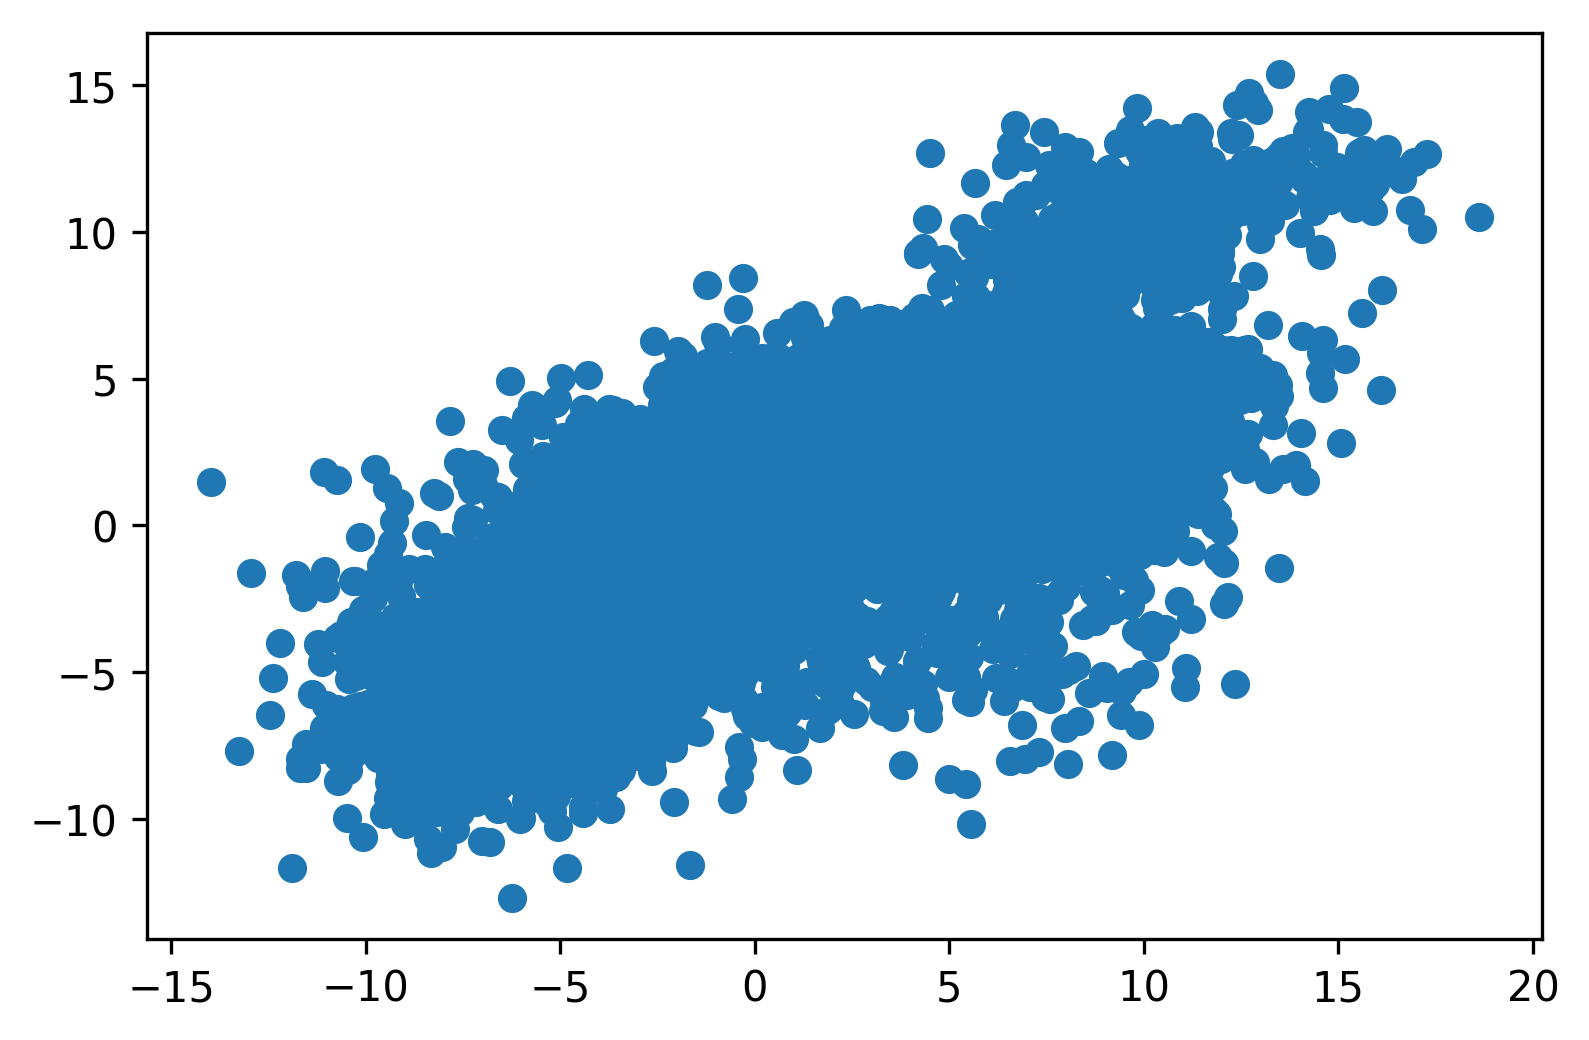

In [61]:
y = cadrres_output_dict['pred_test_df'].values.flatten()
x = cadrres_output_dict['obs_test_df'].values.flatten()
plt.scatter(x[~np.isnan(x)], y[~np.isnan(x)])